In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Conv2D, BatchNormalization, Reshape, \
                        MaxPool2D, GlobalAveragePooling2D, LeakyReLU, UpSampling2D, Flatten, Conv2DTranspose 
from keras.models import Model
from keras.losses import mean_squared_error, binary_crossentropy, categorical_crossentropy
from keras.utils import plot_model
from keras import backend as K

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import save_img
import keras

import numpy as np
import matplotlib.pyplot as plt
import os
import pydot
from PIL import Image
import tensorflow as tf
import random 

Using TensorFlow backend.


In [2]:
## HELPER METHODS

# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [3]:
'''
Getting some examples from the dataset to test reconstruction
'''

dataDir = "/Volumes/HardDrive/Fonts/datasetOnlyAlpha/"
x_test = []

# How many results we want
numResults = 50

for i, file in enumerate(os.listdir(dataDir)[numResults:numResults+50]):
    if file[0:2] == "._":
        file = file[2:]
    fontImg = load_img(dataDir+file).convert('L')
    fontImgArr = img_to_array(fontImg)
    x_test.append(fontImgArr)

x_test = np.asarray(x_test)

x_test = x_test.astype('float32') / 255
print(x_test.shape)


(50, 512, 512, 1)


In [4]:
# Load the model
image_size = x_test.shape[1]
num_channels = 1
input_shape = (image_size, image_size, num_channels)
latent_dim = 100

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  80          encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 8)  32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 1168        batch_normalization_1[0][0]      
____________________________________________________________________________________________

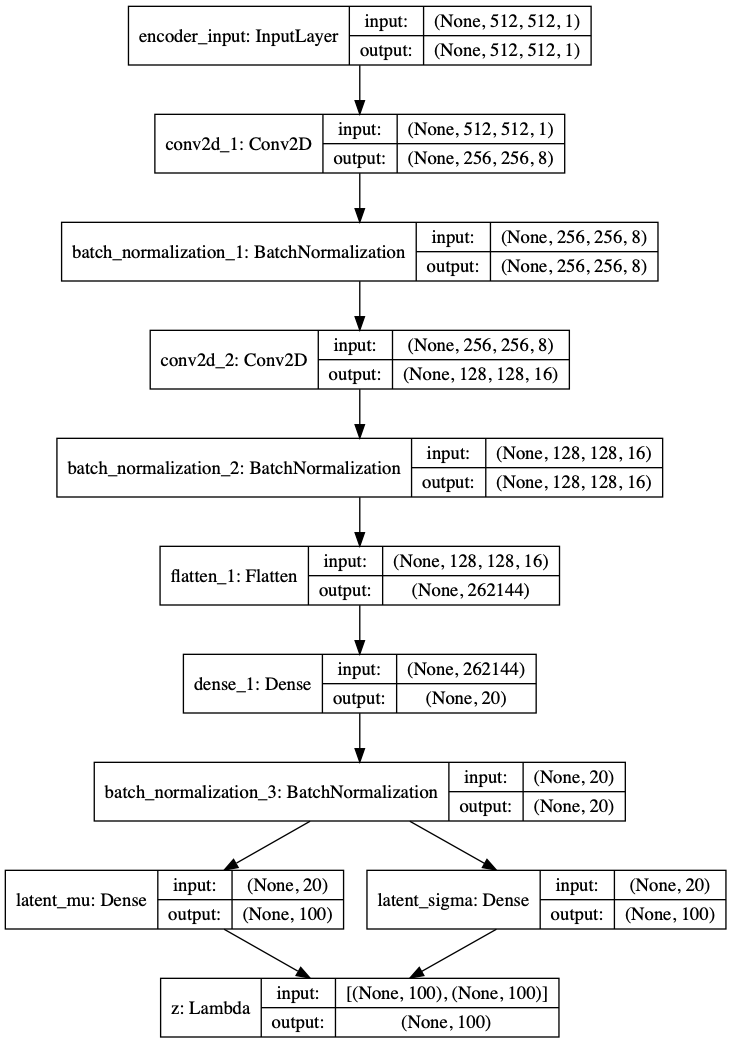

In [5]:
# # =================
# # Encoder Model
# # =================

inputs      = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(inputs)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
z_mean      = Dense(latent_dim, name='latent_mu')(x)
z_log_var   = Dense(latent_dim, name='latent_sigma')(x)
z       = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

conv_shape = K.int_shape(cx)

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='fonts_vae_encoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 262144)            26476544  
_________________________________________________________________
batch_normalization_7 (Batch (None, 262144)            1048576   
_________________________________________________________________
reshape_2 (Reshape)          (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 256, 256, 16)      2320      
_________________________________________________________________
batch_normalization_8 (Batch (None, 256, 256, 16)      64        
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 512, 512, 8)       1160

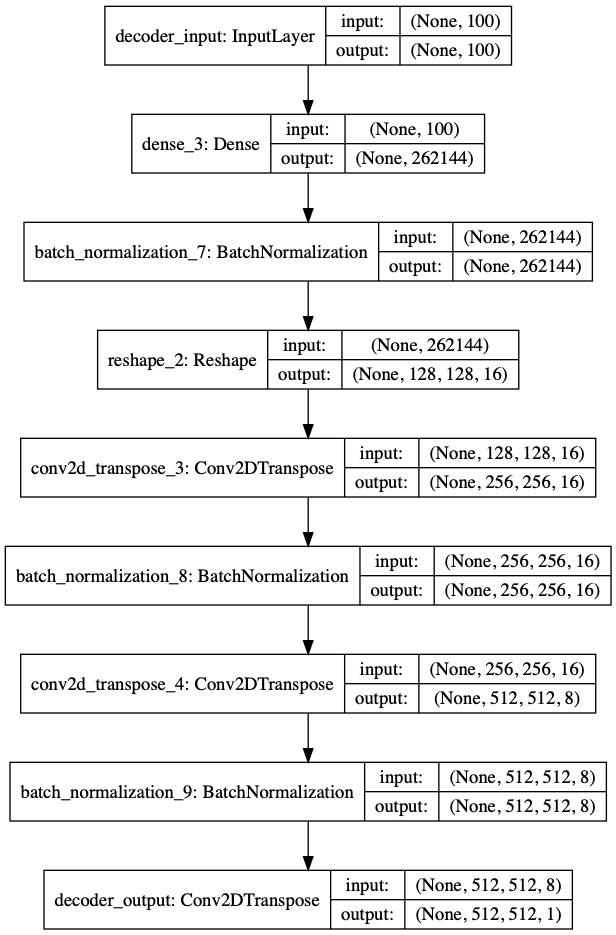

In [7]:
# # =================
# # Decoder Model
# # =================

# Definition
latent_inputs   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(latent_inputs)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)
outputs     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='fonts_vae_decoder.png', show_shapes=True)

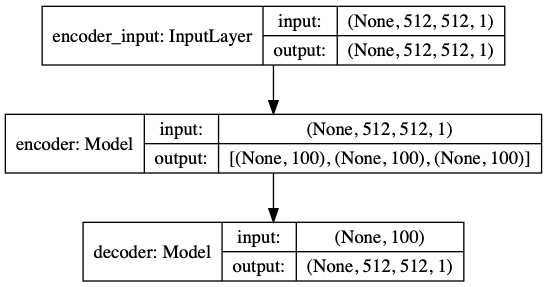

In [8]:
# instantiate VAE model
out = decoder(encoder(inputs)[2])  # index 2 is the sampled tensor from the mean and std
vae = Model(inputs, out, name='vae_fonts')
plot_model(vae, to_file="vae_model.png", show_shapes=True)

In [9]:
# Load the trained weights into the model
vae.load_weights("/Users/yigitatay/Desktop/FONT_GENERATOR/checkpoints/vae_wih_all_data.h5")

In [10]:
## FOR TESTING THE RECONSTRUCTION
for i in range(len(x_test)):
    test_ex = x_test[i]
    test_ex = np.reshape(test_ex, [1, 512, 512, 1])
    result = (np.reshape(vae.predict(test_ex), [512, 512]) * 255).astype('uint8')
    image = Image.fromarray(result, 'L')
    image.save("/Users/yigitatay/Desktop/FONT_GENERATOR/vae_reconstruction/result_font%d.png" % i)

In [13]:
## FOR TESTING THE DECODER MODEL WITH PURELY RANDOM (NORMALLY-DISTRIBUTED) INPUT
num_generate = 20  # How many fonts we want to generate
std_dev = 5        # standard deviation of the random normal
mean = 0.0         # mean of the random normal
for i in range(num_generate):
    latent_space = np.random.normal(mean, std_dev, 100)
    latent_space = np.reshape(latent_space, [1, 100])
    generation = decoder.predict(latent_space)
    generation = (np.reshape(generation, [512, 512]) * 255).astype('uint8')
    gen_image = Image.fromarray(generation, 'L')
    gen_image.save("/Users/yigitatay/Desktop/FONT_GENERATOR/genarated_fonts_with_random_input/gen_image.png")